# Predict Reviews with BERT in the Notebook (AdHoc)

In [1]:
!pip install -q pip --upgrade
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0 --upgrade --ignore-installed
!pip install -q transformers==2.8.0

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.2 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.2 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
jupyterlab 1.2.6 requires jupyterlab_server~=1.0.0, but you'll have jupyterlab-server 1.1.0 which is incompatible.
awswrangler 1.2.0 requires numpy~=1.18.0, but you'll have numpy 1.19.1 which is incompatible.
awscli 1.18.119 requires rsa<=4.5.0,>=3.1.2, but you'll have rsa 4.6 which is incompatible.


### _It's OK if you see ERRORs ^^ above ^^.  Please ignore._

# Restart the Kernel

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Retrieve the Training Job Name

In [2]:
%store -r training_job_name

In [3]:
print('Previous training_job_name: {}'.format(training_job_name))

Previous training_job_name: tensorflow-training-2020-08-22-19-35-37-636


# Download the Trained Model

In [4]:
models_dir = './models'

In [5]:
# Download the model and output artifacts from AWS S3
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz $models_dir/model.tar.gz

download: s3://sagemaker-us-west-2-250107111215/tensorflow-training-2020-08-22-19-35-37-636/output/model.tar.gz to models/model.tar.gz


In [6]:
import tarfile
import pickle as pkl

#!ls -al ./models

tar = tarfile.open('{}/model.tar.gz'.format(models_dir))
tar.extractall(path=models_dir)
tar.close()

In [7]:
!ls -al $models_dir

total 487052
drwxrwxr-x  7 ec2-user ec2-user      4096 Aug 22 19:51 .
drwxrwxr-x 11 ec2-user ec2-user      4096 Aug 22 19:51 ..
drwxr-xr-x  2 ec2-user ec2-user      4096 Aug 22 19:44 code
drwxr-xr-x  2 ec2-user ec2-user      4096 Aug 22 19:44 metrics
-rw-rw-r--  1 ec2-user ec2-user 498712368 Aug 22 19:45 model.tar.gz
drwxr-xr-x  2 ec2-user ec2-user      4096 Aug 22 19:38 tensorboard
drwxr-xr-x  3 ec2-user ec2-user      4096 Aug 22 19:38 tensorflow
drwxr-xr-x  3 ec2-user ec2-user      4096 Aug 22 19:38 transformers


# Load the Model

In [8]:
transformer_model_dir = '{}/transformers/fine-tuned/'.format(models_dir)

!ls -al $transformer_model_dir

total 261692
drwxr-xr-x 2 ec2-user ec2-user      4096 Aug 22 19:43 .
drwxr-xr-x 3 ec2-user ec2-user      4096 Aug 22 19:38 ..
-rw-r--r-- 1 ec2-user ec2-user      1358 Aug 22 19:43 config.json
-rw-r--r-- 1 ec2-user ec2-user 267959068 Aug 22 19:43 tf_model.h5


In [9]:
cat $transformer_model_dir/config.json

{
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true

In [10]:
import os
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(transformer_model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

In [11]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

inference_device = -1 # CPU: -1, GPU: 0
print('inference_device {}'.format(inference_device))

inference_device -1


In [12]:
from transformers import TextClassificationPipeline

inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=inference_device) # -1 is CPU, >= 0 is GPU

# THESE PREDICTIONS WILL NOT BE ACCURATE  

Here are the reasons:
* we are not using the full dataset
* we are only training for 50 steps
* we are using a small training cluster

_This same BERT model achieves close to 97% accuracy when training longer, using a larger training cluster, and using more data._

In [13]:
review = """I loved it!"""
print(review, inference_pipeline(review))

I loved it! [{'label': 1, 'score': 0.22779624}]


In [14]:
review = """Not that good."""
print(review, inference_pipeline(review))

Not that good. [{'label': 1, 'score': 0.2296228}]


# Test Model

In [15]:
import csv

df_test_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']]

df_test_reviews = df_test_reviews.sample(n=100)

df_test_reviews.shape

(100, 2)

In [16]:
df_test_reviews.head()

,review_body,star_rating
92820,"Whenever I try to run to scan my PC, I always ...",1
18334,TurboTax 2014 Form 8606 and individual tax-fre...,1
63709,I had immediate issues develop and a quick cal...,3
98365,Great value for buck. The option is extremely...,5
81167,Do not buy this upgrade does not work<br />And...,1


In [17]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']
    
y_test = df_test_reviews['review_body'].map(predict)

y_test

92820    2
18334    2
63709    2
98365    2
81167    2
        ..
31894    2
73005    1
48358    2
19010    2
63081    2
Name: review_body, Length: 100, dtype: int64

In [18]:
y_actual = df_test_reviews['star_rating']

y_actual

92820    1
18334    1
63709    3
98365    5
81167    1
        ..
31894    1
73005    3
48358    4
19010    3
63081    2
Name: star_rating, Length: 100, dtype: int64

# Classification Report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_actual))

              precision    recall  f1-score   support

           1       0.19      0.26      0.22        19
           2       1.00      0.05      0.09        81
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.09       100
   macro avg       0.24      0.06      0.06       100
weighted avg       0.85      0.09      0.12       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracy

In [20]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_actual))

Accuracy:  0.09


# Confusion Matrix

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 5  0  2  2 10]
 [21  4  9 14 33]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


<Figure size 432x288 with 0 Axes>

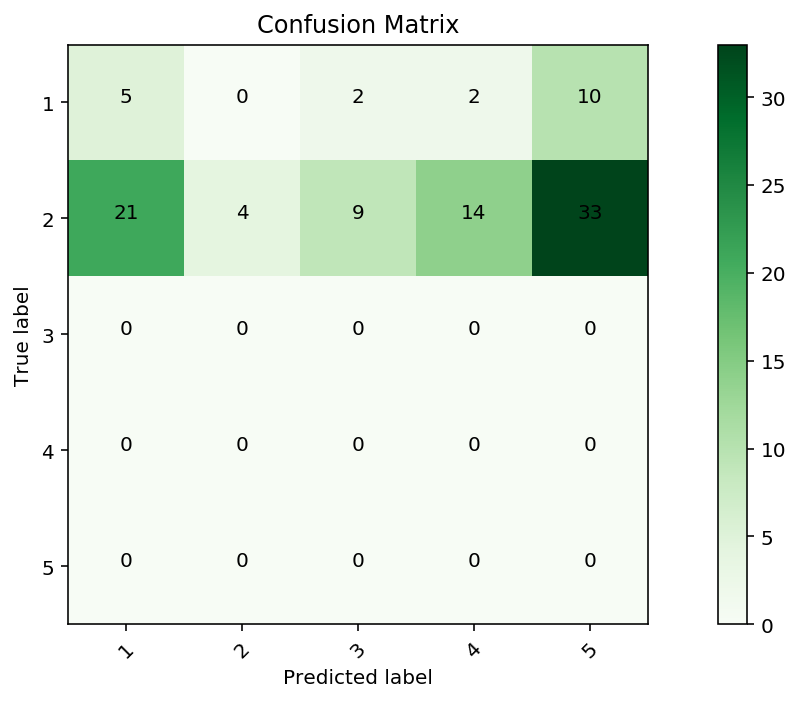

In [22]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();